In [1]:
import matplotlib.pyplot as plt
%matplotlib inline    
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import sys, copy
from pathlib import Path
lib_dir = (Path("__file__").parent).resolve()
if str(lib_dir) not in sys.path: sys.path.insert(0, str(lib_dir))
from FastAutoAugment.networks import WideResNet
from FastAutoAugment.data import get_dataloaders, get_pre_datasets
from theconf import Config as C, ConfigArgumentParser
from PIL import Image
from sklearn.manifold import TSNE
from matplotlib.pyplot import cm
from FastAutoAugment.networks import get_model, num_class
from FastAutoAugment.metrics import accuracy
import numpy as np
from collections import Counter
import pandas as pd

In [45]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [46]:
C.get()["aug"] = "clean"
C.get()["cutout"] = 16
C.get()["cv_num"] = 5

In [47]:
total_trainset, testset = get_pre_datasets("cifar10_svhn", 128, "/home/server32/data/")
print(len(total_trainset))

50000


In [48]:
result = torch.load("/home/server32/yongsu/fast-autoaugment/FastAutoAugment/result/mix_v5_gr2_repeat2_cleanchild_b50/summary.pt")
repeat = 2
cv_num = 5
gr_num = 2
result.keys()

dict_keys(['gr_results', 'gr_dist_collector', 'bench_policy_group', 'final_policy_group', 'aug_affs', 'aug_divs', 'bench_affs', 'bench_divs'])

10


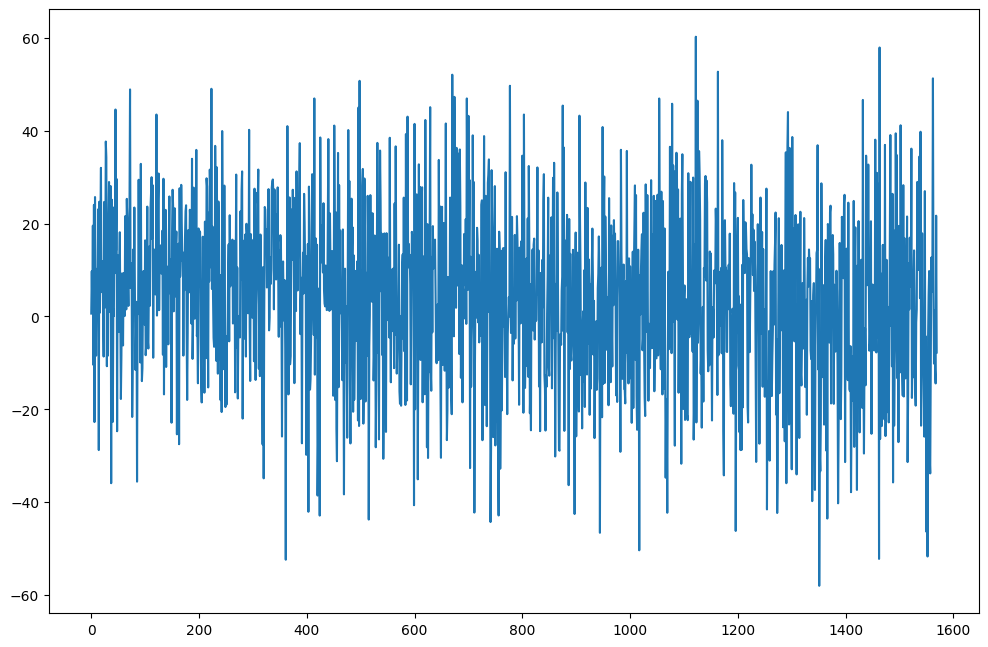

In [49]:
pol_losses = result['gr_results']
print(len(pol_losses))
plt.plot([x for pol in pol_losses for x in pol])

In [49]:
gr_dist_move = result['gr_dist_collector']
print(len(gr_dist_move))
print(len(gr_dist_move[0]))
print(gr_dist_move[0][:100])

5
100000
[1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0]


In [50]:
childnet = WideResNet(40, 2, dropout_rate=0.0, num_classes=20).cuda()
path = "/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/cifar10_svhn_wresnet40_2_clean_ratio0.4_fold0.model"
ckpt = torch.load(path)
if 'model' in ckpt:
    childnet.load_state_dict(ckpt['model'])
else:
    childnet.load_state_dict(ckpt)
childnet.feature_out = True
# _, trainloader, validloader, testloader = get_dataloaders("cifar10_svhn", 128,"/home/server32/data",0.4)
loader = torch.utils.data.DataLoader(
                    total_trainset, batch_size=128, shuffle=False, num_workers=4,
                    drop_last=False)
features = []
for data, label in loader:
    data = data.cuda()
    feature = childnet(data)
    features.append(feature.cpu().detach().numpy())
    del data, label
del childnet
fts = np.concatenate(features)
print(fts.shape)

(50000, 128)


In [51]:
model = TSNE(learning_rate=200, n_iter=1000, perplexity=50, verbose=1, n_jobs=-1)
transformed = model.fit_transform(fts)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 50000 samples in 1.026s...
[t-SNE] Computed neighbors for 50000 samples in 176.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

In [52]:
xs = transformed[:,0]
ys = transformed[:,1]

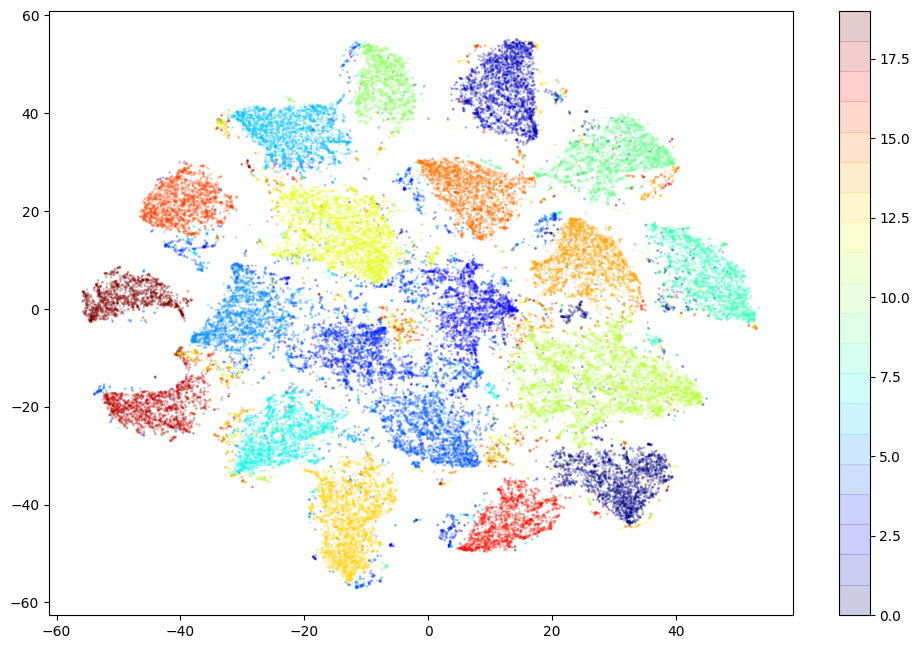

In [53]:
cmap = cm.get_cmap('jet', 20)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=total_trainset.targets, cmap=cmap)
plt.colorbar()
plt.show()

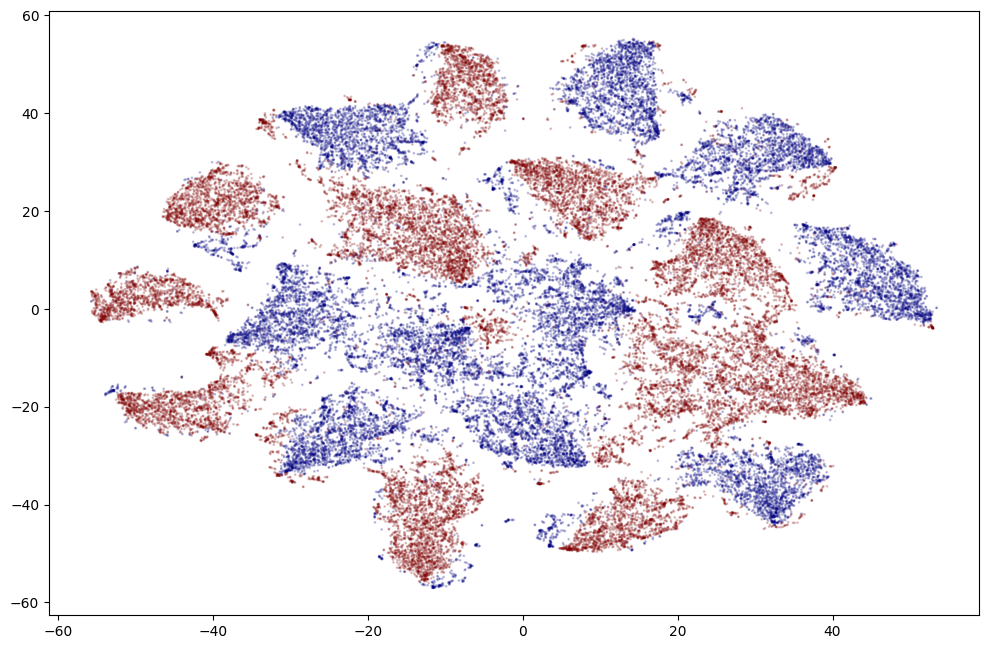

In [55]:
cmap = cm.get_cmap('jet', 2)
plt.scatter(xs,ys,s=1.,alpha=0.2,c=[1 if x<10 else 2 for x in total_trainset.targets], cmap=cmap)
plt.show()

Counter({0: 33625, 1: 16375})


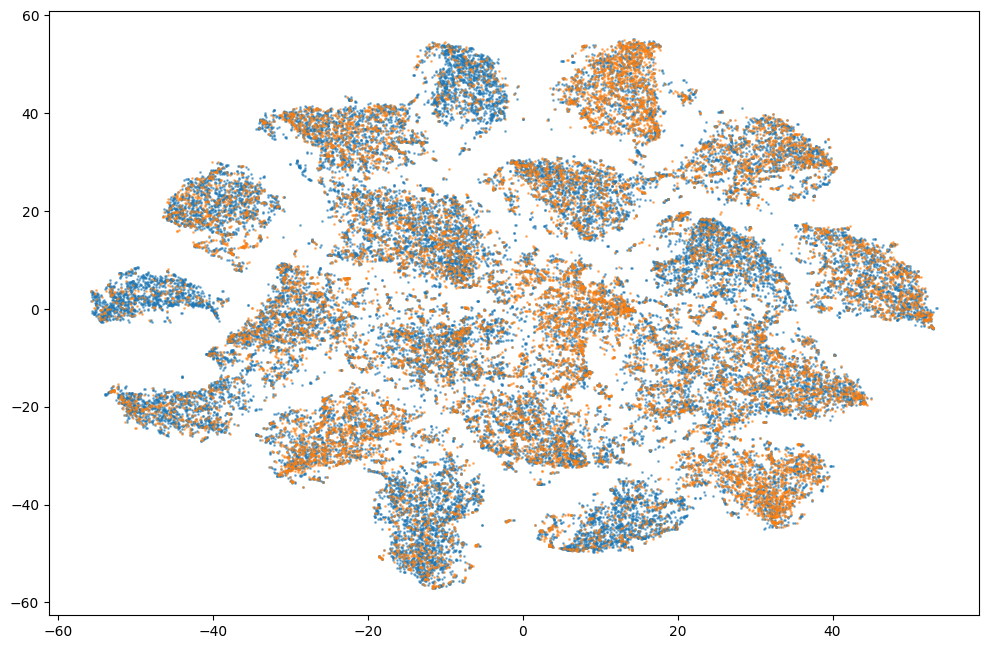

In [56]:
gr_ids = np.array(gr_dist_move[0][:len(fts)])
print(Counter(gr_ids))
idx = {}
for i in range(max(gr_ids)+1):
    idx[i] = gr_ids==i
for id in idx:
    plt.scatter(xs[idx[id]],ys[idx[id]],s=1.,alpha=0.5, cmap=cmap)
plt.show()


In [58]:
cmap[0]

TypeError: 'LinearSegmentedColormap' object does not support indexing

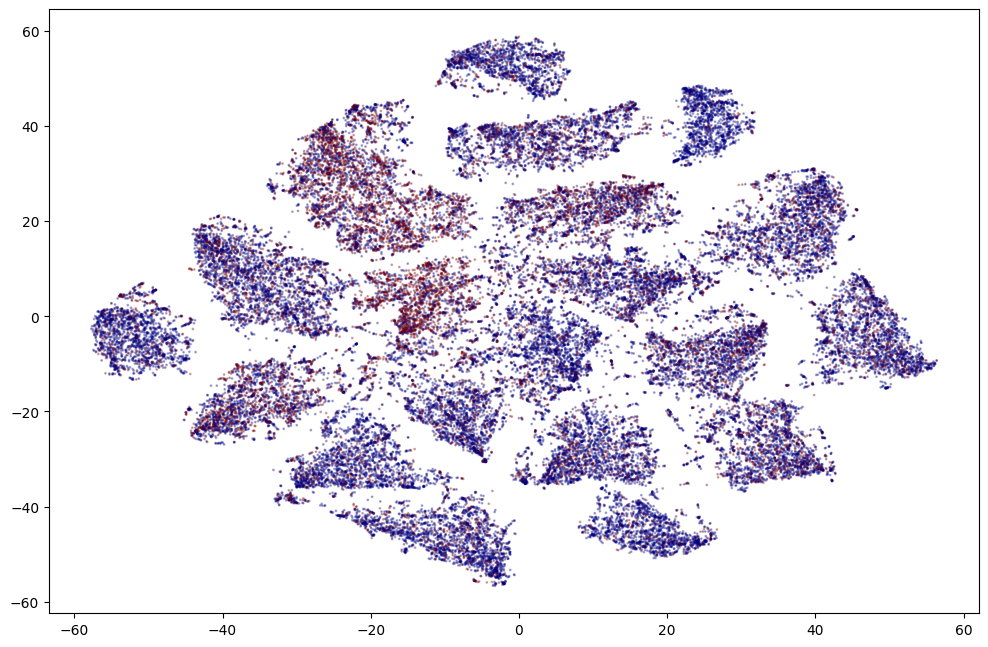

In [40]:
cmap = cm.get_cmap('jet', 2)
gr_ids = gr_dist_move[0][len(fts):]
plt.scatter(xs,ys,s=1.,alpha=0.3,c=gr_ids, cmap=cmap)
plt.show()

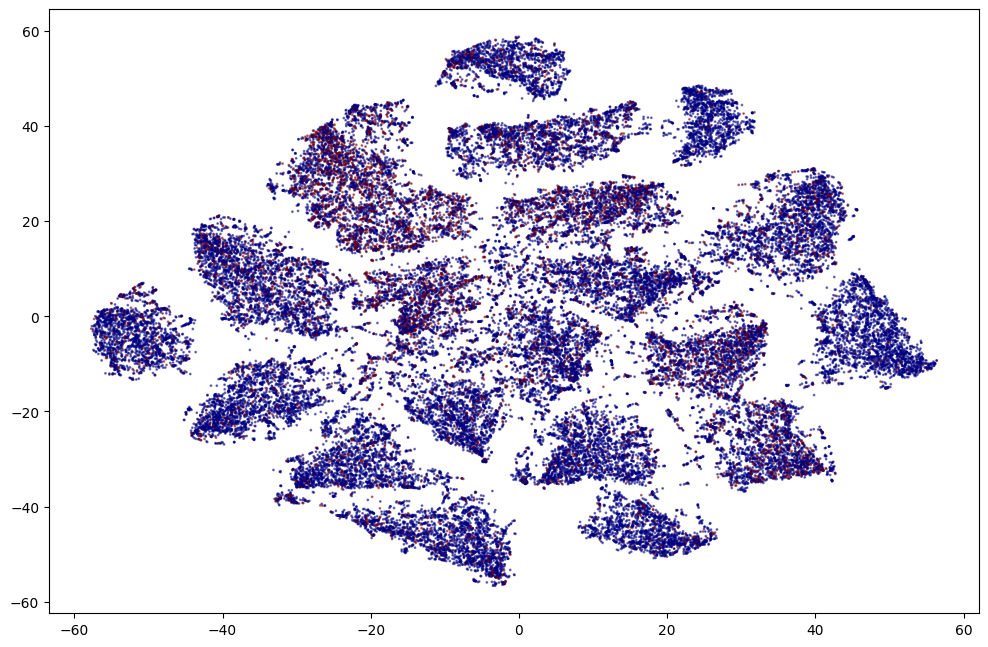

In [41]:
cmap = cm.get_cmap('jet', 3)
gr_ids = np.array(gr_dist_move[4][len(fts):])
plt.scatter(xs,ys,s=1.,alpha=0.5,c=gr_ids, cmap=cmap)
plt.show()

In [27]:
_, trainloader, validloader, testloader = get_dataloaders("cifar10_svhn", 128, "/home/server32/data/", 0.0, gr_id=0, gr_ids=gr_ids)

10000


In [26]:
print(len(testloader.dataset))

19153


In [6]:
load_path = "/home/server32/yongsu/fast-autoaugment/FastAutoAugment/models/logging_b1000/search_cifar10_svhn_wresnet40_2_group2_4_cv0_ratio0.4_bo_result.csv"
result_csv = pd.read_csv(load_path)
minus_loss = result_csv['minus_loss']
acc = result_csv["top1_valid"]

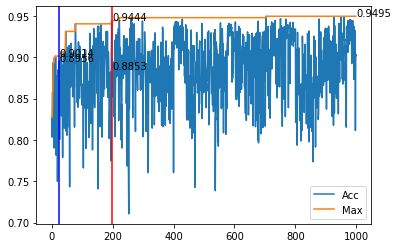

In [7]:
maxline = [max(acc[:x]) for x in range(1,len(acc))]
plt.plot(acc, label="Acc")
plt.plot(maxline, label="Max")
plt.axvline(x=199,c='red')
plt.text(200, acc[199], "{:.4f}".format(acc[199]))
plt.text(200, maxline[198], "{:.4f}".format(maxline[198]))
plt.axvline(x=24,c='blue')
plt.text(25, acc[24], "{:.4f}".format(acc[24]))
plt.text(25, maxline[23], "{:.4f}".format(maxline[23]))
plt.text(len(acc), maxline[-1], "{:.4f}".format(maxline[-1]))
plt.legend()
plt.show()